**Root Cause Analysis of Financial Consumer Complaints : A Case Study Using IBM Granite on the CFPB Dataset**

Maulana Zulfikar Aziz

maulanazulfikarrz@gmail.com

# Setup

## Install Libraries That Required to Call IBM Granite

In [ ]:
!pip install -q langchain_community
!pip install -q replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.8 MB/s eta 0:00:00


## Import Required Libraries

In [ ]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import ast
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Data Understanding

In [ ]:
# Read the data
data = pd.read_csv("complaints-2025-08-09_05_53.csv")

In [ ]:
# How the data look like?
data.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,06/10/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,The Fair Credit Reporting Act ( 15 U.S. Code 1...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75119,NaN,Consent provided,Web,06/10/25,Closed with non-monetary relief,Yes,NaN,13988446
1,06/04/25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,I kindly request that you investigate this mat...,NaN,"EQUIFAX, INC.",NV,89183,NaN,Consent provided,Web,06/04/25,Closed with explanation,Yes,NaN,13885991
2,06/05/25,Checking or savings account,Checking account,Closing an account,Funds not received from closed account,"Sometime on XX/XX/XXXX, my partner asked for p...",Company has responded to the consumer and the ...,U.S. BANCORP,CA,94621,NaN,Consent provided,Web,06/05/25,Closed with explanation,Yes,NaN,13920498
3,06/06/25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,I have Been with XXXX XXXX For over 1 year for...,Company believes it acted appropriately as aut...,Kikoff Inc.,UT,843XX,NaN,Consent provided,Web,06/18/25,Closed with explanation,Yes,NaN,13938966
4,07/10/25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I have an account on XXXX XXXX.... One of my f...,Company has responded to the consumer and the ...,"Fidelity National Information Services, Inc. (...",AZ,86406,NaN,Consent provided,Web,07/10/25,Closed with explanation,Yes,NaN,14565084


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45224 entries, 0 to 45223
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 45224 non-null  object 
 1   Product                       45224 non-null  object 
 2   Sub-product                   45224 non-null  object 
 3   Issue                         45224 non-null  object 
 4   Sub-issue                     44069 non-null  object 
 5   Consumer complaint narrative  45224 non-null  object 
 6   Company public response       32418 non-null  object 
 7   Company                       45224 non-null  object 
 8   State                         45079 non-null  object 
 9   ZIP code                      45224 non-null  object 
 10  Tags                          3288 non-null   object 
 11  Consumer consent provided?    45224 non-null  object 
 12  Submitted via                 45224 non-null  object 
 13  D

Because our goal is to do Root Cause Analysis on Consumer Complaint Narratives, we have to choose only the used columns,
1. Date Received
2. Product
3. Sub-Product
4. Issue
5. Consumer complaint narrative
6. Company

In [ ]:
data = data[['Date received', 'Product', 'Sub-product', 'Issue',
       'Consumer complaint narrative', 'Company']]

# Exploratory Data Analysis & Data Cleaning

In [ ]:
# Check the columns' information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45224 entries, 0 to 45223
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 45224 non-null  object
 1   Product                       45224 non-null  object
 2   Sub-product                   45224 non-null  object
 3   Issue                         45224 non-null  object
 4   Consumer complaint narrative  45224 non-null  object
 5   Company                       45224 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [ ]:
# Check the missing values of the data
data.isna().sum()

,0
Date received,0
Product,0
Sub-product,0
Issue,0
Consumer complaint narrative,0
Company,0


In [ ]:
# Check the duplicate values of the data
data.duplicated().sum()

np.int64(9030)

In [ ]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)

In [ ]:
# Change the type of column "Date received"
data["Date received"] = pd.to_datetime(data["Date received"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36194 entries, 0 to 45223
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 36194 non-null  datetime64[ns]
 1   Product                       36194 non-null  object        
 2   Sub-product                   36194 non-null  object        
 3   Issue                         36194 non-null  object        
 4   Consumer complaint narrative  36194 non-null  object        
 5   Company                       36194 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.9+ MB


/tmp/ipython-input-2277849262.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date received"] = pd.to_datetime(data["Date received"])


In [ ]:
# Overview of the cleaned data
data.head(5)

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company
0,2025-06-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,The Fair Credit Reporting Act ( 15 U.S. Code 1...,"TRANSUNION INTERMEDIATE HOLDINGS, INC."
1,2025-06-04,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,I kindly request that you investigate this mat...,"EQUIFAX, INC."
2,2025-06-05,Checking or savings account,Checking account,Closing an account,"Sometime on XX/XX/XXXX, my partner asked for p...",U.S. BANCORP
3,2025-06-06,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,I have Been with XXXX XXXX For over 1 year for...,Kikoff Inc.
4,2025-07-10,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,I have an account on XXXX XXXX.... One of my f...,"Fidelity National Information Services, Inc. (..."


## Column : Product

In [ ]:
# Check the unique values of Product
print("The number of unique values of Product : {}".format(data.Product.nunique()))
data.Product.value_counts()

The number of unique values of Product : 11


,count
Product,
Credit reporting or other personal consumer reports,24972
Debt collection,3812
Checking or savings account,2429
Credit card,2083
Mortgage,889
"Money transfer, virtual currency, or money service",632
Vehicle loan or lease,581
"Payday loan, title loan, personal loan, or advance loan",295
Student loan,275


In [ ]:
# Create a function to automatically create horizontal bar chart
def hbar(vc, title, ylabel) :
  # Set style
  plt.style.use("seaborn-v0_8-whitegrid")
  sns.set_palette("pastel")

  # Create figure
  fig, ax = plt.subplots(figsize=(8, 5))

  # Fancy barh chart
  bars = ax.barh(vc.index, vc.values,
                color=sns.color_palette("coolwarm", len(counts_product)),
                edgecolor="black", linewidth=1, alpha=0.85)

  # Add value labels
  for bar in bars:
      width = bar.get_width()
      ax.text(width + vc.max()*0.01,  # small offset
              bar.get_y() + bar.get_height()/2,
              f"{int(width):,}",
              va="center", fontsize=10, fontweight="bold")

  # Titles & labels
  ax.set_title(title, fontsize=14, fontweight="bold")
  ax.set_xlabel("Number of Complaints", fontsize=12)
  ax.set_ylabel(ylabel, fontsize=12)

  # Remove top/right spines for clean look
  sns.despine()

  plt.tight_layout()
  plt.show()

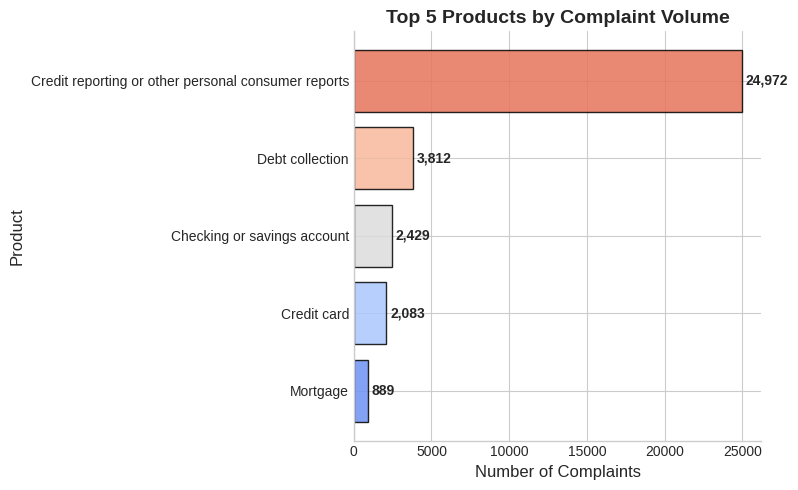

In [ ]:
# Visualize the top 5 values of Product

# Prepare data
counts_product = data.Product.value_counts().head(5).sort_values()

hbar(counts_product,"Top 5 Products by Complaint Volume", "Product")

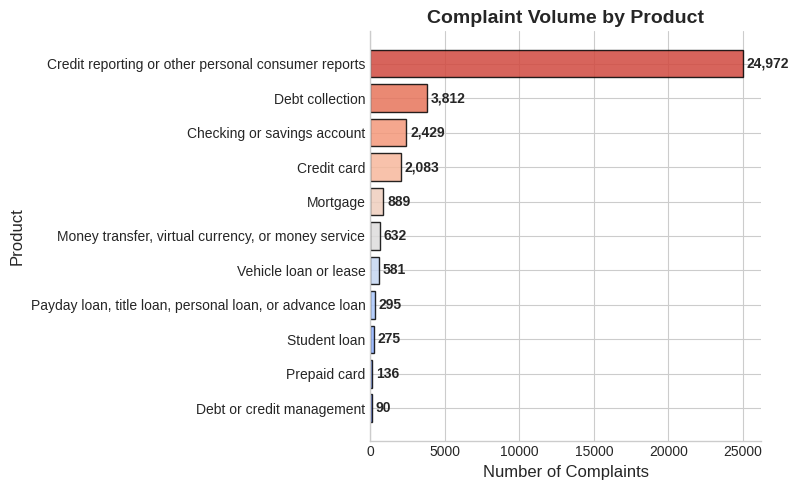

In [ ]:
# Visualize the unique values of Product

# Prepare data
counts_product = data.Product.value_counts().sort_values()

hbar(counts_product,"Complaint Volume by Product", "Product")

## Column : Subproduct

In [ ]:
# Check the unique values of Product
print("The number of unique values of Subproduct : {}".format(data["Sub-product"].nunique()))
data["Sub-product"].value_counts()

The number of unique values of Subproduct : 52


,count
Sub-product,
Credit reporting,24719
Checking account,2042
General-purpose credit card or charge card,1784
I do not know,1226
Credit card debt,724
Other debt,613
Loan,503
Conventional home mortgage,486
Telecommunications debt,420


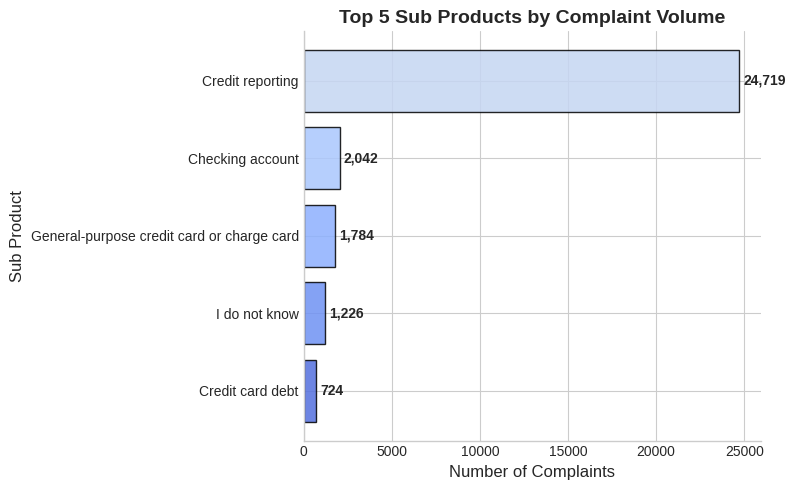

In [ ]:
# Visualize the top 5 values of Sub-product

# Prepare the data
counts_subproduct = data["Sub-product"].value_counts()[:5].sort_values()

hbar(counts_subproduct,"Top 5 Sub Products by Complaint Volume", "Sub Product")

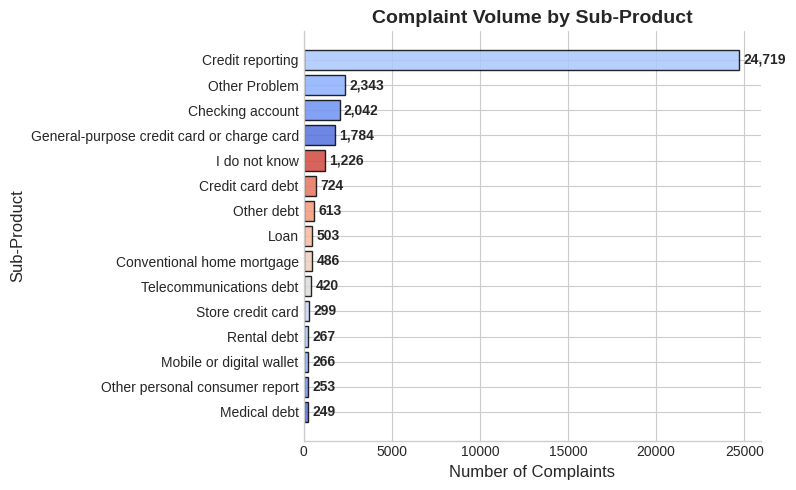

In [ ]:
# Visualize the unique values of Subproduct

# Prepare the data
counts_subproduct = data["Sub-product"].value_counts()[:14]
counts_subproduct_other = data["Sub-product"].value_counts()[14:].values
counts_subproduct["Other Problem"] = counts_subproduct_other.sum() # Group categories beyond top 14 as 'Other Problem'
counts_subproduct = counts_subproduct.sort_values()

hbar(counts_subproduct,"Complaint Volume by Sub-Product", "Sub-Product")

## Column : Issue

In [ ]:
# Check the unique values of Issue
print("The number of unique values of Issue : {}".format(data.Issue.nunique()))
data.Issue.value_counts()

The number of unique values of Issue : 83


,count
Issue,
Incorrect information on your report,11788
Improper use of your report,9280
Problem with a company's investigation into an existing problem,3833
Attempts to collect debt not owed,1756
Managing an account,1317
...,...
Lost or stolen refund,1
Problem with cash advance,1
Problem with overdraft,1


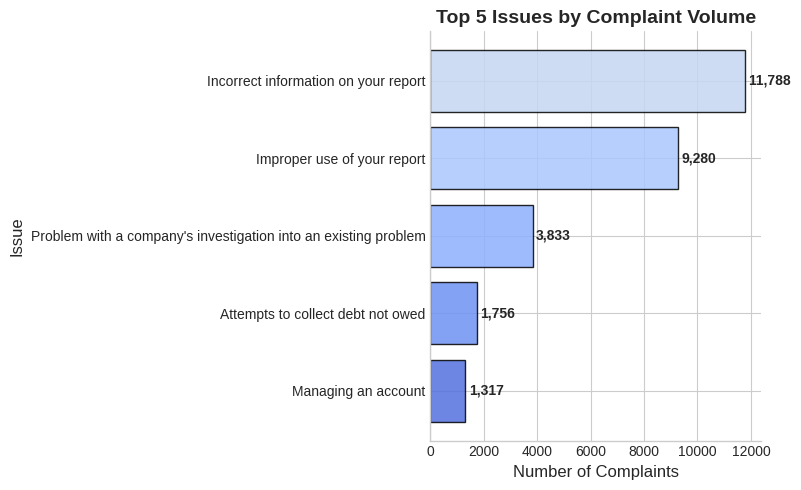

In [ ]:
# Visualize the top 5 values of Issue

# Prepare the data
counts_Issue = data.Issue.value_counts()[:5].sort_values()

hbar(counts_Issue,"Top 5 Issues by Complaint Volume", "Issue")

In [ ]:
# Check the unique values of Issue
print("Number of unique values on column Issue : {}".format(data.Issue))
data.Issue.unique()

array(['Incorrect information on your report', 'Closing an account',
       'Improper use of your report',
       "Problem with a company's investigation into an existing problem",
       'Problem with a lender or other company charging your account',
       'Dealing with your lender or servicer',
       'Problem with a purchase shown on your statement',
       'Getting a credit card', 'Fraud or scam', 'Managing an account',
       'Problem when making payments', 'Repossession',
       'Attempts to collect debt not owed', 'Closing on a mortgage',
       'Problems receiving the advance',
       'Written notification about debt', 'Fees or interest',
       'Unauthorized withdrawals or charges', 'Opening an account',
       'Managing the loan or lease', 'Trouble during payment process',
       'Closing your account',
       'Took or threatened to take negative or legal action',
       'Other features, terms, or problems',
       'Unauthorized transactions or other transaction problem',
  

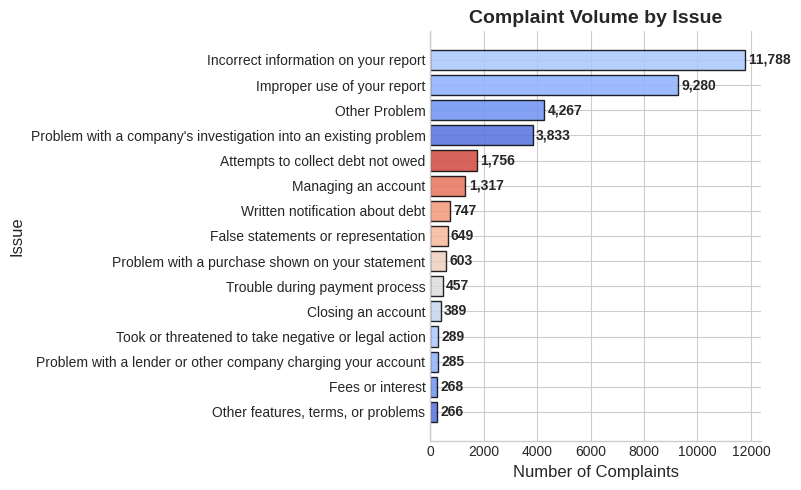

In [ ]:
# Visualize the unique values of Issue

# Prepare the Data
counts_issue = data.Issue.value_counts()[:14]
counts_issue_other = data.Issue.value_counts()[14:].values
counts_issue["Other Problem"] = counts_issue_other.sum() # Group categories beyond top 14 as 'Other Problem'
counts_issue = counts_issue.sort_values()

hbar(counts_issue,"Complaint Volume by Issue", "Issue")

### Categorizing Issues Into 15 Categories Using IBM Granite

In [ ]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [ ]:
# Define the issue
issues = data.Issue.unique()

# Define the issue text
issues_text = "\n".join([f"Issue {i+1}: {issue}" for i, issue
in enumerate(issues)])
prompt = f"""
You have 83 consumer complaint issue categories listed below.

Your task:
1. Analyze the issues and identify patterns, themes, and similarities.
2. Group them into exactly 15 **meaningful, distinct, and non-overlapping** categories.
3. Each category name must be short, clear, and descriptive (3–6 words), covering related
issues without being too broad or too narrow.
4. Avoid redundancy, each issue should logically fit into only one category.
5. Do not include examples or explanations in the output.

List of issues:
{issues_text}

Output format:
Numbered list (1–15) containing only the category names.
"""


# Set model parameters for prompting
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 256,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.0,
"stopping_criteria": "length (256 tokens)",
"stopping_sequence": None
}

# Invoke the model with the prompt
response = output.invoke(prompt)
# Print the response
print("Granite Model Response:\n")
print(response)

Granite Model Response:

1. Inaccurate Reporting
2. Account Management Issues
3. Company Investigation Failures
4. Lender/Company Disputes
5. Payment Problems
6. Debt Collection Harassment
7. Mortgage Closing Complications
8. Advance Payment Issues
9. Debt Notification Disputes
10. Fee/Interest Controversies
11. Account Opening/Closing
12. Loan/Lease Management
13. Payment Processing Troubles
14. Negative Actions Threats
15. Miscellaneous Financial Problems


In [ ]:
# Define the issue
issues = data.Issue.unique()[:28]

prompt = f"""
You have a list of 28 issue categories that need to be mapped into exactly one of the 15 master categories I will give you.

Instructions:
1. You must assign **each of the 28 issue categories** to **exactly one** of the 15 master categories.
2. Use the master category names **exactly as written**. Do not rename, merge, split, or invent new categories.
3. Choose the most semantically accurate mapping based on the meaning of the issue category — not just on keyword similarity.
4. If an issue could fit more than one master category, choose the one that most directly matches its primary meaning in consumer finance contexts.
5. Output the result **only** as a valid Python dictionary with double quotes around all strings. Do not include explanations, comments, Markdown code fences, or any extra text.
6. Ensure all 15 master categories appear at least once in the mapping.
7. Do not repeat or create any new issue categories — use the 28 given exactly as written.
8. The output must start with {{ and end with }} — no other characters allowed before or after.
9. If you violate these rules, your answer will be rejected.

List of 28 issue categories:
{issues}

List of 15 master categories:
{response}

Output format:
A valid Python dictionary where:
- Key = issue category (string, exactly from the 28 list above)
- Value = master category (string, exactly from the 15 list above)

Example:
{{
    "Managing an account": "Account Management Issues",
    "Fraud or scam": "Fraud and Scams"
}}
"""


# Set model parameters for prompting
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 512,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.0,
"stopping_criteria": "length (512 tokens)",
"stopping_sequence": None
}

# Invoke the model with the prompt
response_2 = output.invoke(prompt)
# Print the response
print("Granite Model Response:\n")
print(response_2)

Granite Model Response:


{
    "Incorrect information on your report": "Inaccurate Reporting",
    "Closing an account": "Account Opening/Closing",
    "Improper use of your report": "Inaccurate Reporting",
    "Problem with a company's investigation into an existing problem": "Company Investigation Failures",
    "Problem with a lender or other company charging your account": "Lender/Company Disputes",
    "Dealing with your lender or servicer": "Loan/Lease Management",
    "Problem with a purchase shown on your statement": "Payment Problems",
    "Getting a credit card": "Account Opening/Closing",
    "Fraud or scam": "Miscellaneous Financial Problems",
    "Managing an account": "Account Management Issues",
    "Problem when making payments": "Payment Problems",
    "Repossession": "Loan/Lease Management",
    "Attempts to collect debt not owed": "Debt Collection Harassment",
    "Closing on a mortgage": "Mortgage Closing Complications",
    "Problems receiving the advance": "Advan

In [ ]:
# Define the issue
issues = data.Issue.unique()[28:56]

prompt = f"""
You have a list of 28 issue categories that need to be mapped into exactly one of the 15 master categories I will give you.

Instructions:
1. You must assign **each of the 28 issue categories** to **exactly one** of the 15 master categories.
2. Use the master category names **exactly as written**. Do not rename, merge, split, or invent new categories.
3. Choose the most semantically accurate mapping based on the meaning of the issue category — not just on keyword similarity.
4. If an issue could fit more than one master category, choose the one that most directly matches its primary meaning in consumer finance contexts.
5. Output the result **only** as a valid Python dictionary with double quotes around all strings. Do not include explanations, comments, Markdown code fences, or any extra text.
6. Ensure all 15 master categories appear at least once in the mapping.
7. Do not repeat or create any new issue categories — use the 28 given exactly as written.
8. The output must start with {{ and end with }} — no other characters allowed before or after.

List of 28 issue categories:
{issues}

List of 15 master categories:
{response}

Output format:
A valid Python dictionary where:
- Key = issue category (string, exactly from the 28 list above)
- Value = master category (string, exactly from the 15 list above)

Example:
{{
    "Managing an account": "Account Management Issues",
    "Fraud or scam": "Fraud and Scams"
}}
"""

# Set model parameters for prompting
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 512,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.0,
"stopping_criteria": "length (512 tokens)",
"stopping_sequence": None
}

# Invoke the model with the prompt
response_3 = output.invoke(prompt)
# Print the response
print("Granite Model Response:\n")
print(response_3)

Granite Model Response:

{
    "Money was not available when promised": "Payment Problems",
    "False statements or representation": "Inaccurate Reporting",
    "Struggling to pay mortgage": "Loan/Lease Management",
    "Problem caused by your funds being low": "Payment Problems",
    "Charged upfront or unexpected fees": "Fee/Interest Controversies",
    "Applying for a mortgage or refinancing an existing mortgage": "Mortgage Closing Complications",
    "Trouble using your card": "Payment Processing Troubles",
    "Communication tactics": "Negative Actions Threats",
    "Struggling to pay your loan": "Loan/Lease Management",
    "Problem with fraud alerts or security freezes": "Inaccurate Reporting",
    "Struggling to repay your loan": "Loan/Lease Management",
    "Electronic communications": "Negative Actions Threats",
    "Problem with a purchase or transfer": "Miscellaneous Financial Problems",
    "Confusing or missing disclosures": "Inaccurate Reporting",
    "Other transaction

In [ ]:
# Define the issue
issues = data.Issue.unique()[56:]

prompt = f"""
You have a list of 28 issue categories that need to be mapped into exactly one of the 15 master categories I will give you.

Instructions:
1. You must assign **each of the 28 issue categories** to **exactly one** of the 15 master categories.
2. Use the master category names **exactly as written**. Do not rename, merge, split, or invent new categories.
3. Choose the most semantically accurate mapping based on the meaning of the issue category — not just on keyword similarity.
4. If an issue could fit more than one master category, choose the one that most directly matches its primary meaning in consumer finance contexts.
5. Output the result **only** as a valid Python dictionary with double quotes around all strings. Do not include explanations, comments, Markdown code fences, or any extra text.
6. Ensure all 15 master categories appear at least once in the mapping.
7. Do not repeat or create any new issue categories — use the 28 given exactly as written.
8. The output must start with {{ and end with }} — no other characters allowed before or after.

List of 28 issue categories:
{issues}

List of 15 master categories:
{response}

Output format:
A valid Python dictionary where:
- Key = issue category (string, exactly from the 28 list above)
- Value = master category (string, exactly from the 15 list above)

Example:
{{
    "Managing an account": "Account Management Issues",
    "Fraud or scam": "Fraud and Scams"
}}
"""


# Set model parameters for prompting
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 512,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.0,
"stopping_criteria": "length (512 tokens)",
"stopping_sequence": None
}

# Invoke the model with the prompt
response_4 = output.invoke(prompt)
# Print the response
print("Granite Model Response:\n")
print(response_4)

Granite Model Response:

{
    "Other service problem": "Miscellaneous Financial Problems",
    "Managing, opening, or closing your mobile wallet account": "Account Opening/Closing",
    "Getting a loan or lease": "Loan/Lease Management",
    "Problem with a company's investigation into an existing issue": "Company Investigation Failures",
    "Can't stop withdrawals from your bank account": "Payment Problems",
    'Identity theft protection or other monitoring services': "Miscellaneous Financial Problems",
    'Struggling to pay your bill': "Payment Problems",
    "Getting a loan": "Loan/Lease Management",
    "Didn't provide services promised": "Debt Notification Disputes",
    'Trouble accessing funds in your mobile or digital wallet': "Payment Problems",
    'Vehicle was repossessed or sold the vehicle': "Loan/Lease Management",
    "Can't contact lender or servicer": "Lender/Company Disputes",
    'Problem adding money': "Payment Problems",
    'Problem with cash advance': "Advanc

In [ ]:
# Change the data type from str to dict
dict_response_2 = ast.literal_eval(response_2)
dict_response_3 = ast.literal_eval(response_3)
dict_response_4 = ast.literal_eval(response_4)

# Merge the responses
categories = dict_response_2 | dict_response_3 | dict_response_4

# Re-categorize
issue_counts = data.Issue.value_counts()
category_counts = issue_counts.groupby(issue_counts.index.map(categories)).sum().sort_values(ascending=True)
category_counts

,count
Issue,
Advance Payment Issues,4
Mortgage Closing Complications,277
Lender/Company Disputes,290
Fee/Interest Controversies,413
Payment Processing Troubles,628
Negative Actions Threats,701
Debt Notification Disputes,766
Loan/Lease Management,925
Miscellaneous Financial Problems,1046


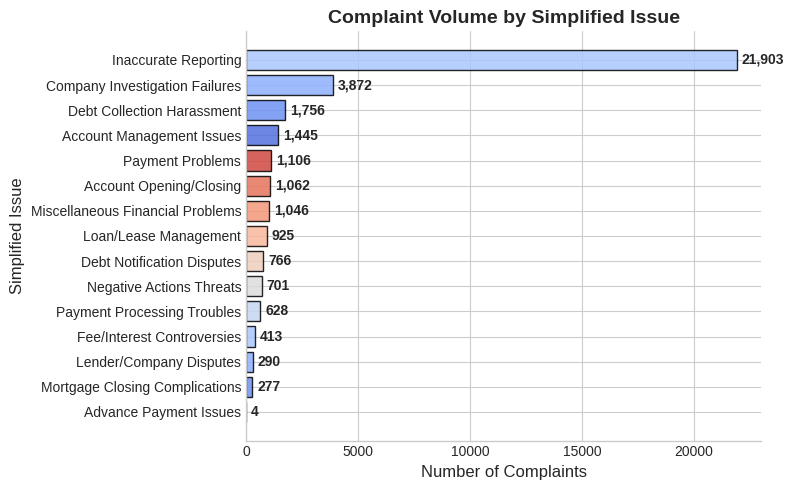

In [ ]:
# Visualize the Complaint Volume by Simplified Issue
hbar(category_counts,"Complaint Volume by Simplified Issue", "Simplified Issue")

## Column : Company

In [ ]:
print("Number of companies : {}".format(data.Company.nunique()))

Number of companies : 958


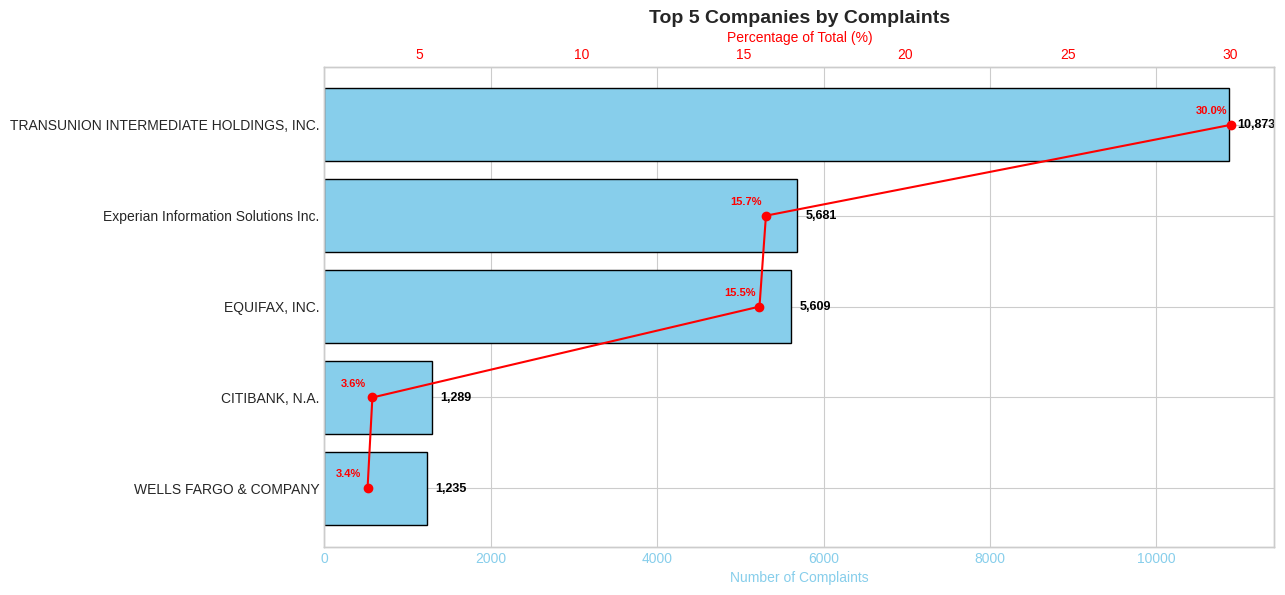

In [ ]:
# We will Visualize Top 5 Companies by Complaints using Horiztonal Pareto Chart

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Sort descending so highest first
top5 = (
    data.groupby('Company')['Consumer complaint narrative']
    .count()
    .sort_values(ascending=False)  # biggest first
    .head(5)
)

# Calculate percentage of total
percentage = (top5 / len(data)) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Horizontal bars
ax1.barh(top5.index, top5, color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Complaints', color='skyblue')
ax1.tick_params(axis='x', labelcolor='skyblue')

# Invert so biggest is at top
ax1.invert_yaxis()

# Second axis for percentage
ax2 = ax1.twiny()
ax2.plot(percentage, top5.index, color='red', marker='o')
ax2.set_xlabel('Percentage of Total (%)', color='red')
ax2.tick_params(axis='x', labelcolor='red')

# Add labels to bars
for i, v in enumerate(top5):
    ax1.text(v + 100, i, f"{v:,}", va='center', fontweight='bold', color='black',fontsize=9)

# Labels for percentage — above the dot
for i, p in enumerate(percentage):
    ax2.text(p-0.6, i - 0.1, f"{p:.1f}%", va='bottom', color='red', fontweight='bold', ha='center',fontsize=8)

ax2.grid(False)


# Title and layout
plt.title('Top 5 Companies by Complaints', fontsize=14, fontweight='bold')
plt.tight_layout()

# If still not fitting, manually adjust margins
plt.subplots_adjust(left=0.25, right=1.2, top=0.9, bottom=0.1)

plt.show()

In [ ]:
data["simplified_issue"] = data["Issue"].map(categories)

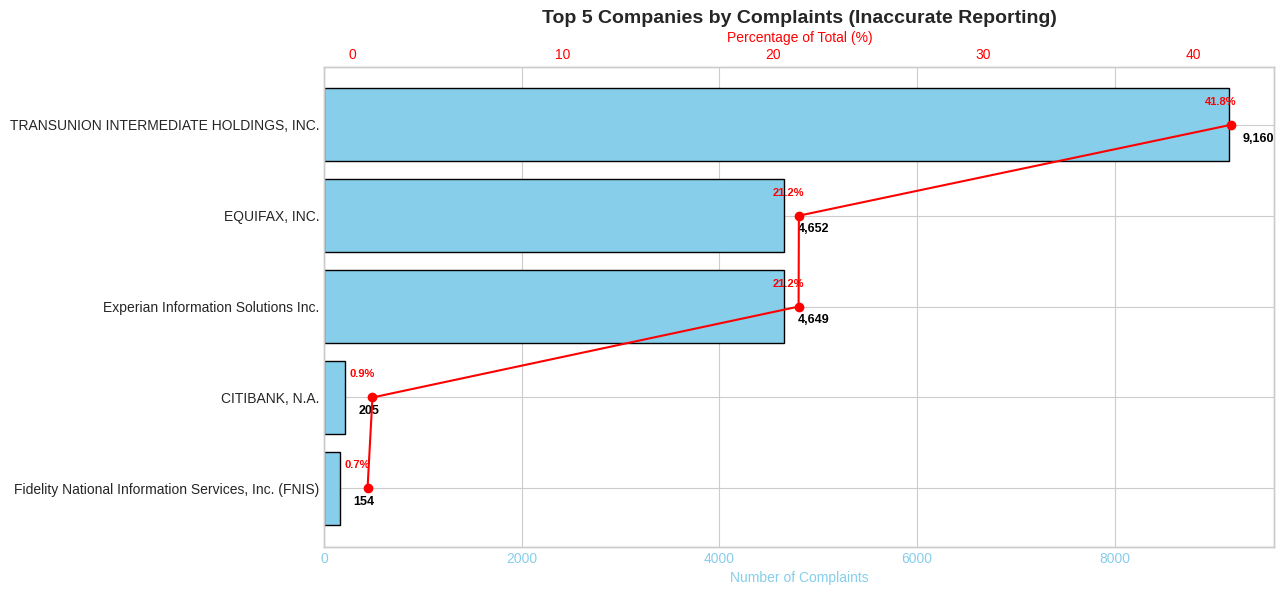

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Sort descending so highest first
top5 = (
    data[data["simplified_issue"]=="Inaccurate Reporting"].groupby('Company')['Consumer complaint narrative']
    .count()
    .sort_values(ascending=False)  # biggest first
    .head(5)
)

# Calculate percentage of total
percentage = (top5 / len(data[data["simplified_issue"]=="Inaccurate Reporting"])) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Horizontal bars
ax1.barh(top5.index, top5, color='skyblue', edgecolor='black')
ax1.set_xlabel('Number of Complaints', color='skyblue')
ax1.tick_params(axis='x', labelcolor='skyblue')

# Invert so biggest is at top
ax1.invert_yaxis()

# Second axis for percentage
ax2 = ax1.twiny()
ax2.plot(percentage, top5.index, color='red', marker='o')
ax2.set_xlabel('Percentage of Total (%)', color='red')
ax2.tick_params(axis='x', labelcolor='red')

# Add labels to bars
for i, v in enumerate(top5):
    ax1.text(v + 140, i+0.15, f"{v:,}", va='center', fontweight='bold', color='black',fontsize=9)

# Labels for percentage — above the dot
for i, p in enumerate(percentage):
    ax2.text(p-0.5, i - 0.2, f"{p:.1f}%", va='bottom', color='red', fontweight='bold', ha='center',fontsize=8)

ax2.grid(False)


# Title and layout
plt.title('Top 5 Companies by Complaints (Inaccurate Reporting)', fontsize=14, fontweight='bold')
plt.tight_layout()

# If still not fitting, manually adjust margins
plt.subplots_adjust(left=0.25, right=1.2, top=0.9, bottom=0.1)

plt.show()

# Consumer Narrative Text Analysis

## Word Clouds

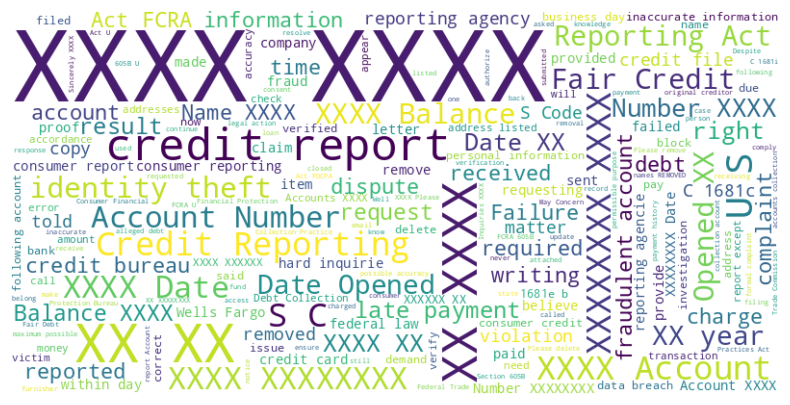

In [ ]:
# Most Frequent words in complaint narrative
# Combine all text into one string
text_data = " ".join(data['Consumer complaint narrative'].astype(str))

# Optional: add stopwords
stop_words = set(STOPWORDS)

# Create the WordCloud
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='viridis'
).generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Change the Redacted text
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].str.replace(r"X{2,}", "<REDACTED>", regex=True)

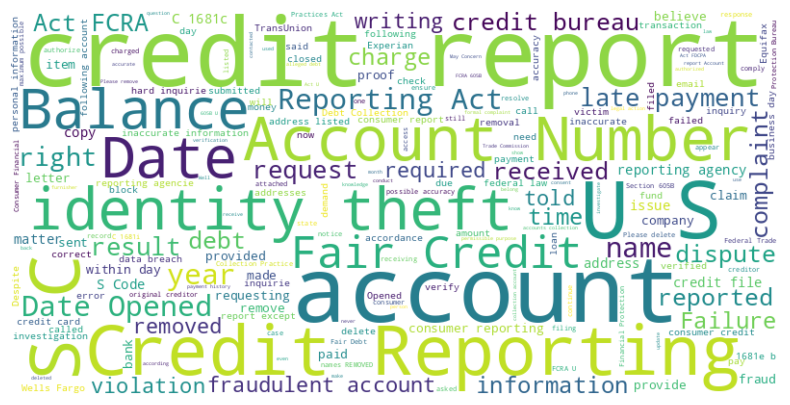

In [ ]:
# Most Frequent words in complaint narrative
# Combine all text into one string
text_data = " ".join(data['Consumer complaint narrative'].astype(str))

# Optional: add stopwords
stop_words = set(STOPWORDS)
stop_words.update(["Redacted"])  # Custom words to ignore
# Create the WordCloud
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='viridis'
).generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word & Character Distribution

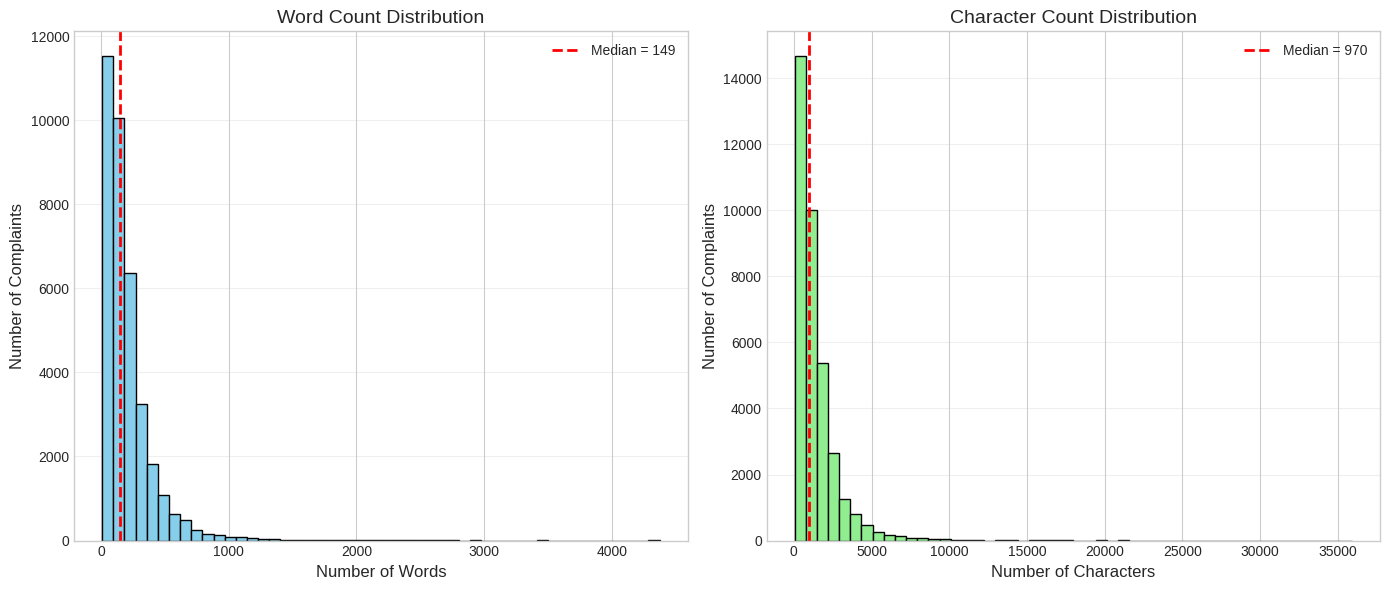

In [ ]:
# Narrative words count distribution

# Word count distribution
word_counts = data["Consumer complaint narrative"].astype(str).apply(lambda x: len(x.split()))
# Character count distribution
char_counts = data["Consumer complaint narrative"].astype(str).str.len()

# Median values
median_words = word_counts.median()
median_chars = char_counts.median()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot word count distribution
axes[0].hist(word_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(median_words, color='red', linestyle='dashed', linewidth=2, label=f'Median = {median_words:.0f}')
axes[0].set_title("Word Count Distribution", fontsize=14)
axes[0].set_xlabel("Number of Words", fontsize=12)
axes[0].set_ylabel("Number of Complaints", fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot character count distribution
axes[1].hist(char_counts, bins=50, color='lightgreen', edgecolor='black')
axes[1].axvline(median_chars, color='red', linestyle='dashed', linewidth=2, label=f'Median = {median_chars:.0f}')
axes[1].set_title("Character Count Distribution", fontsize=14)
axes[1].set_xlabel("Number of Characters", fontsize=12)
axes[1].set_ylabel("Number of Complaints", fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Narrative length and words count median
average_length = data["Consumer complaint narrative"].str.len().median()
average_words_count = data["Consumer complaint narrative"].astype(str).apply(lambda x : len(x.split())).median()
print("The median length of the consumer complaint narratives = {}".format(average_length))
print("The median words count the consumer complaint narratives = {}".format(average_words_count))

The median length of the consumer complaint narratives = 970.0
The median words count the consumer complaint narratives = 149.0


## Daily Narratives

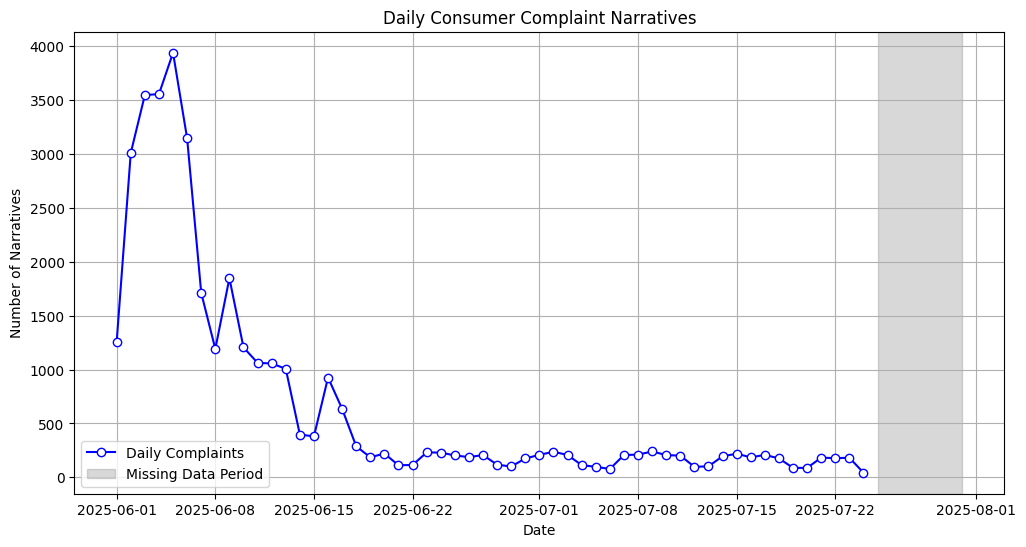

In [ ]:
# Group and count
daily_counts = (
    data.groupby("Date received")["Consumer complaint narrative"]
    .count()
    .sort_index()  # ensure chronological order
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', color="blue",markerfacecolor='white', label='Daily Complaints')

# Highlight incomplete July period
plt.axvspan(pd.Timestamp('2025-07-25'), pd.Timestamp('2025-07-31'),
            color='grey', alpha=0.3, label='Missing Data Period')

plt.title('Daily Consumer Complaint Narratives')
plt.xlabel('Date')
plt.ylabel('Number of Narratives')
plt.legend()
plt.grid(True)
plt.show()

## Daily Complaint by Simplified Issue

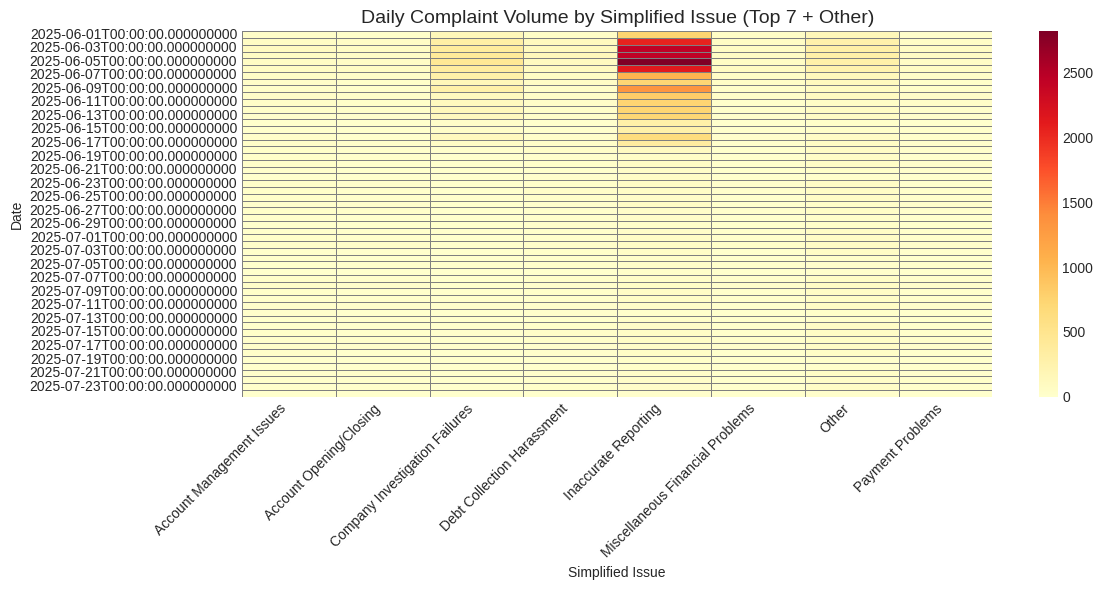

In [ ]:
# 1. Keep top 7 categories, group the rest into "Other"
top_cats = data["simplified_issue"].value_counts().nlargest(7).index
data["simplified_issue_plot"] = data["simplified_issue"].where(
    data["simplified_issue"].isin(top_cats),
    "Other"
)

# 2. Aggregate daily counts
daily_cat_counts = (
    data.groupby(["Date received", "simplified_issue_plot"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap (dates as rows, categories as columns)
heatmap_data = daily_cat_counts.pivot(
    index="Date received",
    columns="simplified_issue_plot",
    values="count"
).fillna(0)

# 3. Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Daily Complaint Volume by Simplified Issue (Top 7 + Other)", fontsize=14)
plt.ylabel("Date")
plt.xlabel("Simplified Issue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Daily Complaint by Issue

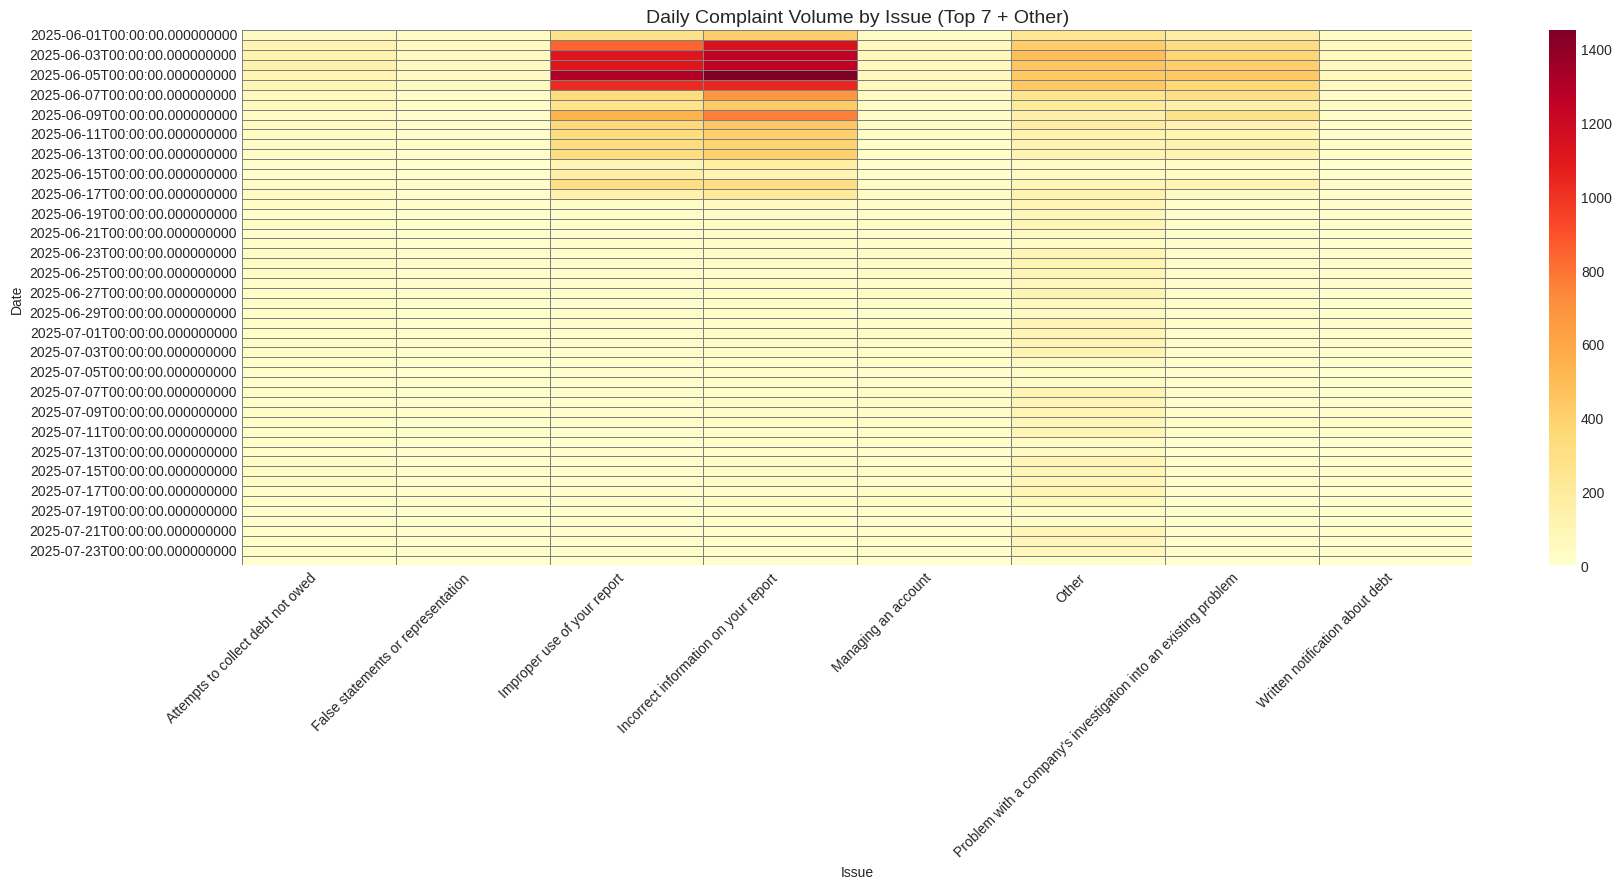

In [ ]:
# 1. Keep top 7 categories, group the rest into "Other"
top_cats = data["Issue"].value_counts().nlargest(7).index
data["issue_plot"] = data["Issue"].where(
    data["Issue"].isin(top_cats),
    "Other"
)

# 2. Aggregate daily counts
daily_cat_counts = (
    data.groupby(["Date received", "issue_plot"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap (dates as rows, categories as columns)
heatmap_data = daily_cat_counts.pivot(
    index="Date received",
    columns="issue_plot",
    values="count"
).fillna(0)

# 3. Plot heatmap
plt.figure(figsize=(18, 9))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Daily Complaint Volume by Issue (Top 7 + Other)", fontsize=14)
plt.ylabel("Date")
plt.xlabel("Issue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Daily Complaint by Product

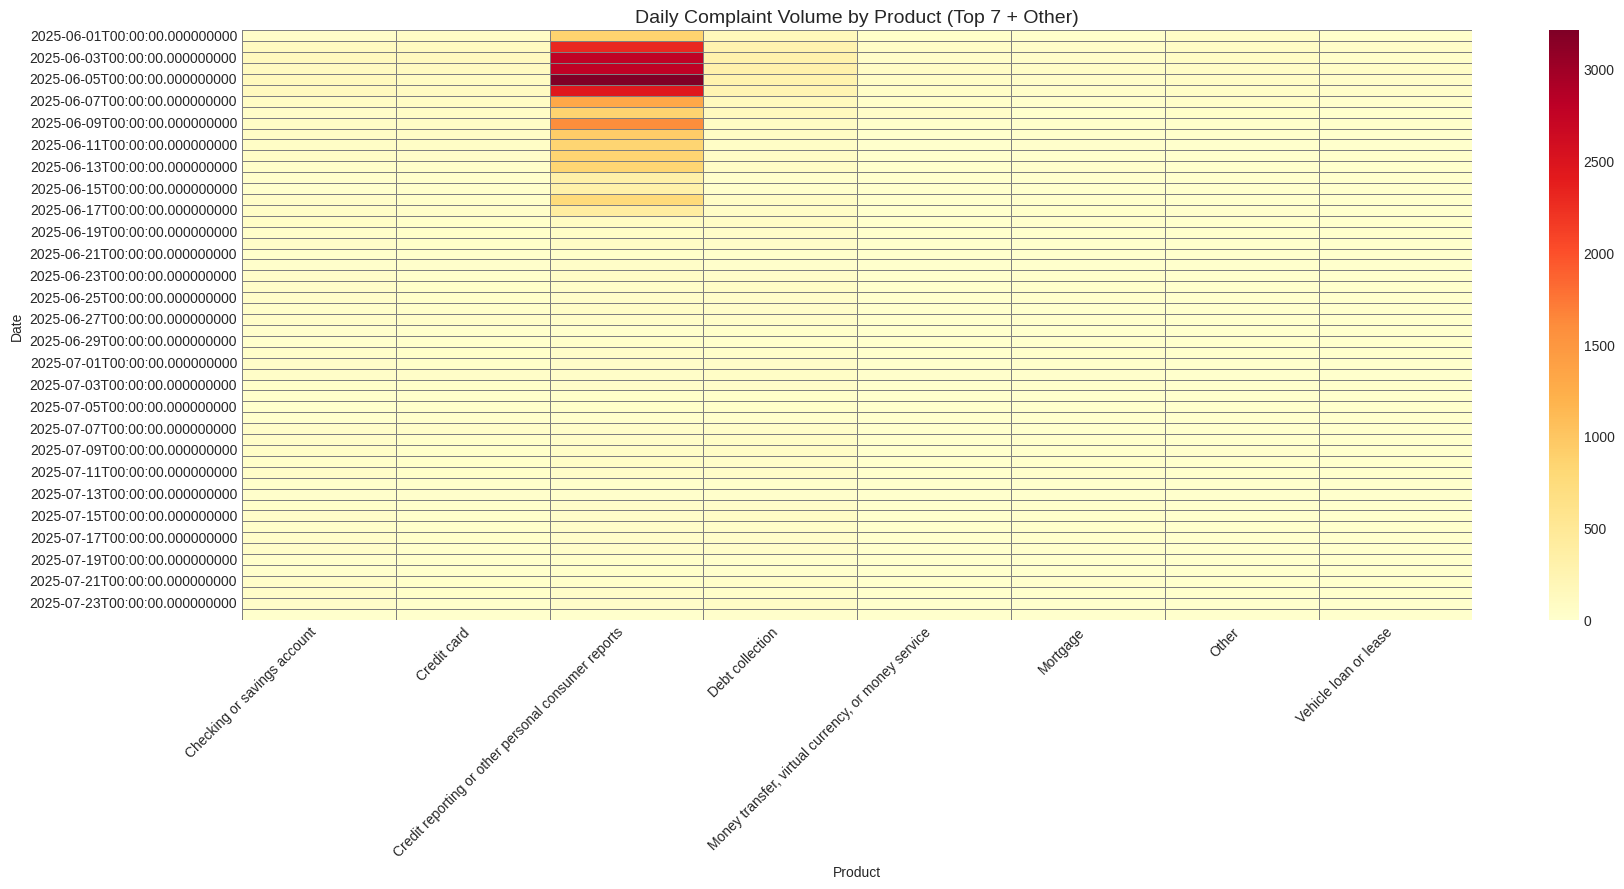

In [ ]:
# 1. Keep top 7 categories, group the rest into "Other"
top_cats = data["Product"].value_counts().nlargest(7).index
data["product_plot"] = data["Product"].where(
    data["Product"].isin(top_cats),
    "Other"
)

# 2. Aggregate daily counts
daily_cat_counts = (
    data.groupby(["Date received", "product_plot"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap (dates as rows, categories as columns)
heatmap_data = daily_cat_counts.pivot(
    index="Date received",
    columns="product_plot",
    values="count"
).fillna(0)

# 3. Plot heatmap
plt.figure(figsize=(18, 9))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Daily Complaint Volume by Product (Top 7 + Other)", fontsize=14)
plt.ylabel("Date")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Daily Complaint by Sub-product

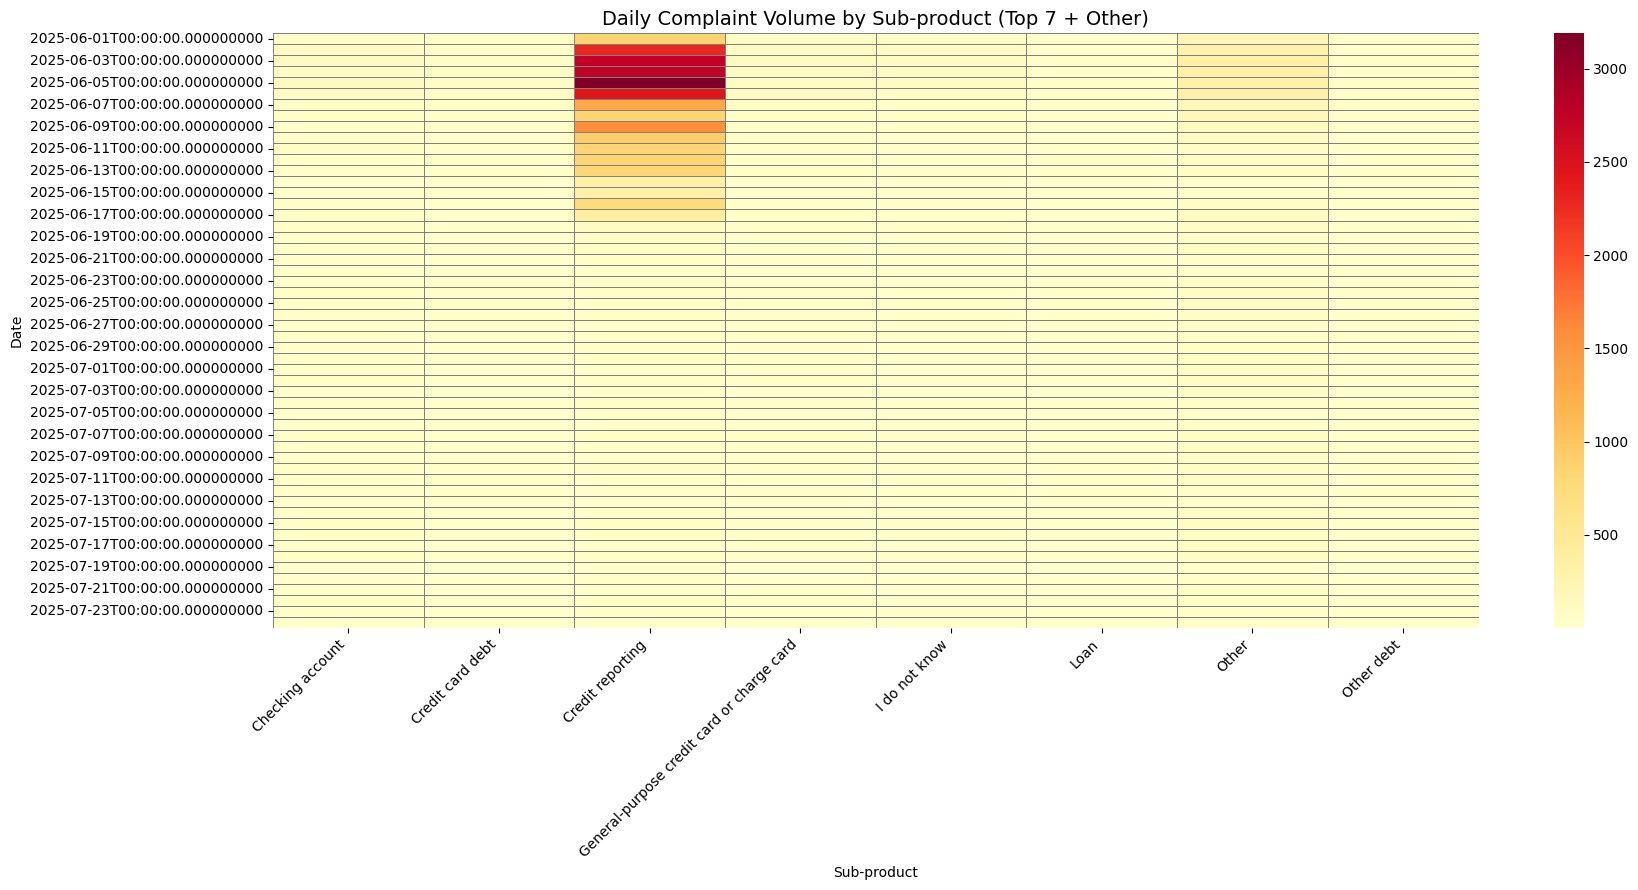

In [ ]:
# 1. Keep top 7 categories, group the rest into "Other"
top_cats = data["Sub-product"].value_counts().nlargest(7).index
data["subproduct_plot"] = data["Sub-product"].where(
    data["Sub-product"].isin(top_cats),
    "Other"
)

# 2. Aggregate daily counts
daily_cat_counts = (
    data.groupby(["Date received", "subproduct_plot"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap (dates as rows, categories as columns)
heatmap_data = daily_cat_counts.pivot(
    index="Date received",
    columns="subproduct_plot",
    values="count"
).fillna(0)

# 3. Plot heatmap
plt.figure(figsize=(18, 9))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Daily Complaint Volume by Sub-product (Top 7 + Other)", fontsize=14)
plt.ylabel("Date")
plt.xlabel("Sub-product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Daily Complaint by Company

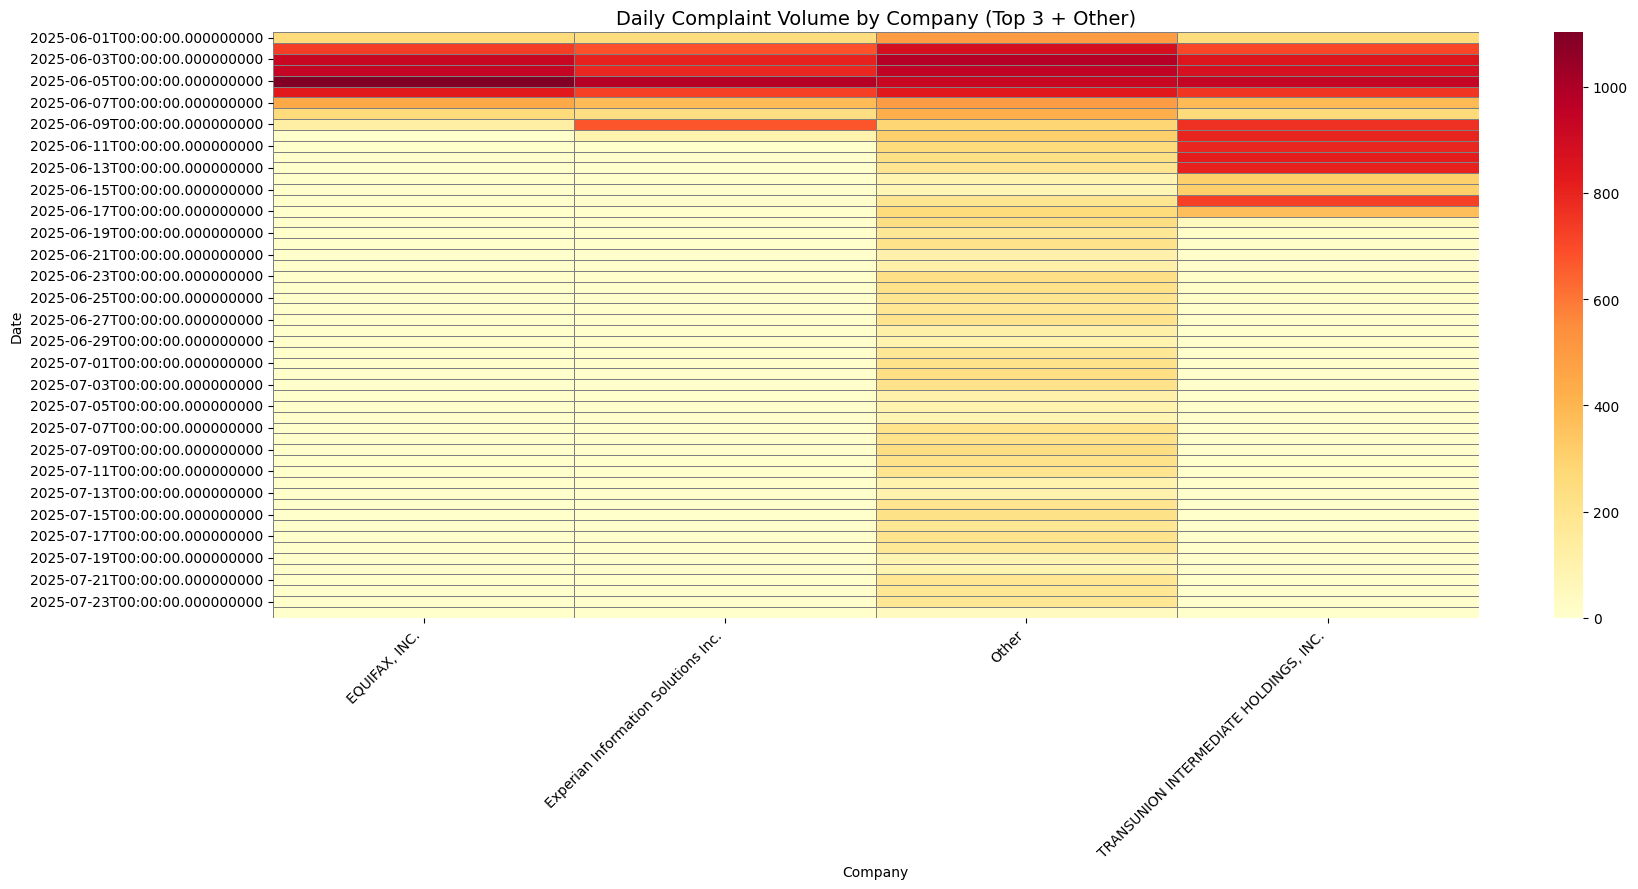

In [ ]:
# 1. Keep top 3 categories, group the rest into "Other"
top_cats = data.groupby("Company")["Consumer complaint narrative"].count().nlargest(3).index
data["company_plot"] = data["Company"].where(
    data["Company"].isin(top_cats),
    "Other"
)

# 2. Aggregate daily counts
daily_cat_counts = (
    data.groupby(["Date received", "company_plot"])
    .size()
    .reset_index(name="count")
)

# Pivot for heatmap (dates as rows, categories as columns)
heatmap_data = daily_cat_counts.pivot(
    index="Date received",
    columns="company_plot",
    values="count"
).fillna(0)

# 3. Plot heatmap
plt.figure(figsize=(18, 9))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor="gray")
plt.title("Daily Complaint Volume by Company (Top 3 + Other)", fontsize=14)
plt.ylabel("Date")
plt.xlabel("Company")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Incident & Root Cause Analysis

## Spike 1

In [ ]:
spike_start = "2025-06-01"
spike_end = "2025-06-08"

# Filter spike and baseline data
spike_df = data[(data["Date received"] >= spike_start) & (data["Date received"] <= spike_end)]
baseline_df = data[(data["Date received"] < spike_start) | (data["Date received"] > spike_end)]

# Count complaints per Simplified Issue
spike_counts = spike_df["simplified_issue"].value_counts()
baseline_counts = baseline_df["simplified_issue"].value_counts()

# Total counts
total_spike = len(spike_df)
total_baseline = len(baseline_df)

# Calculate proportions
spike_pct = (spike_counts / total_spike) * 100
baseline_pct = (baseline_counts / total_baseline) * 100

# Merge into a DataFrame
spike_table = pd.DataFrame({
    "spike%": round(spike_pct,2),
    "baseline%": round(baseline_pct,2)
}).fillna(0)

# Calculate diff
spike_table["diff"] = spike_table["spike%"] - spike_table["baseline%"]

In [ ]:
# Download stopwords once
nltk.download("stopwords")

# Get built-in stopwords
stop_words = set(stopwords.words("english"))
stop_words.update({"redacted", "00"})

# Prepare a column for results
spike_table["top spike phrases"] = ""

# Loop through each simplified_issue
for issue in spike_table.index :
    # Combine all narratives for this issue
    issue_text = " ".join(
        spike_df.loc[spike_df["simplified_issue"] == issue, "Consumer complaint narrative"].dropna()
    )

    # Tokenize and clean
    tokens = re.findall(r'\b\w+\b', issue_text.lower())
    tokens = [t for t in tokens if t not in stop_words]

    # Get top 5 words
    top_phrases = [w for w, _ in Counter(tokens).most_common(5)]

    # Assign to rows with this issue
    spike_table.loc[issue, "top spike phrases"] = ", ".join(top_phrases)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
spike_table = spike_table.sort_values("spike%", ascending=False)
spike_table

,spike%,baseline%,diff,top spike phrases
simplified_issue,,,,
Inaccurate Reporting,67.37,50.66,16.71,"credit, account, report, information, accounts"
Company Investigation Failures,11.87,9.01,2.86,"credit, account, reporting, information, report"
Debt Collection Harassment,3.56,6.72,-3.16,"debt, credit, account, collection, report"
Miscellaneous Financial Problems,2.45,3.52,-1.07,"account, credit, card, bank, year"
Account Management Issues,2.44,6.22,-3.78,"account, bank, funds, credit, check"
Loan/Lease Management,2.15,3.15,-1.00,"loan, payment, account, credit, interest"
Debt Notification Disputes,1.94,2.36,-0.42,"debt, credit, account, report, collection"
Account Opening/Closing,1.90,4.43,-2.53,"account, credit, bank, card, closed"
Payment Problems,1.90,4.72,-2.82,"account, card, credit, dispute, bank"


## Spike 2

In [ ]:
spike_start = "2025-06-09"
spike_end = "2025-06-17"

# Filter spike and baseline data
spike_df = data[(data["Date received"] >= spike_start) & (data["Date received"] <= spike_end)]
baseline_df = data[(data["Date received"] < spike_start) | (data["Date received"] > spike_end)]

# Count complaints per Simplified Issue
spike_counts = spike_df["simplified_issue"].value_counts()
baseline_counts = baseline_df["simplified_issue"].value_counts()

# Total counts
total_spike = len(spike_df)
total_baseline = len(baseline_df)

# Calculate proportions
spike_pct = (spike_counts / total_spike) * 100
baseline_pct = (baseline_counts / total_baseline) * 100

# Merge into a DataFrame
spike_table = pd.DataFrame({
    "spike%": round(spike_pct,2),
    "baseline%": round(baseline_pct,2)
}).fillna(0)

# Calculate diff
spike_table["diff"] = spike_table["spike%"] - spike_table["baseline%"]

In [ ]:
# Get built-in stopwords
stop_words = set(stopwords.words("english"))
stop_words.update({"redacted", "00"})

# Prepare a column for results
spike_table["top spike phrases"] = ""

# Loop through each simplified_issue
for issue in spike_table.index :
    # Combine all narratives for this issue
    issue_text = " ".join(
        spike_df.loc[spike_df["simplified_issue"] == issue, "Consumer complaint narrative"].dropna()
    )

    # Tokenize and clean
    tokens = re.findall(r'\b\w+\b', issue_text.lower())
    tokens = [t for t in tokens if t not in stop_words]

    # Get top 5 words
    top_phrases = [w for w, _ in Counter(tokens).most_common(5)]

    # Assign to rows with this issue
    spike_table.loc[issue, "top spike phrases"] = ", ".join(top_phrases)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
spike_table = spike_table.sort_values("spike%", ascending=False)
spike_table

,spike%,baseline%,diff,top spike phrases
simplified_issue,,,,
Inaccurate Reporting,69.72,57.68,12.04,"credit, report, account, information, reporting"
Company Investigation Failures,11.96,10.31,1.65,"credit, reporting, information, report, account"
Debt Collection Harassment,3.22,5.35,-2.13,"credit, debt, account, report, collection"
Account Management Issues,2.72,4.38,-1.66,"account, bank, money, wells, fargo"
Payment Problems,2.41,3.26,-0.85,"account, credit, card, bank, dispute"
Account Opening/Closing,1.84,3.27,-1.43,"account, credit, bank, card, received"
Miscellaneous Financial Problems,1.61,3.28,-1.67,"account, credit, bank, card, information"
Payment Processing Troubles,1.27,1.88,-0.61,"account, mortgage, payment, escrow, loan"
Debt Notification Disputes,1.22,2.39,-1.17,"debt, credit, account, report, reporting"


## Root Cause Analysis

### Filtering and Sampling

In [ ]:
# Define the date of start and end of each spikes
spike1_start = "2025-06-01"
spike1_end = "2025-06-08"
spike2_start = "2025-06-09"
spike2_end = "2025-06-17"

# Filtering the dataset to get the only spike data
spike1_df = data[(data["Date received"] >= spike1_start) & (data["Date received"] <= spike1_end) & (data["simplified_issue"] == "Inaccurate Reporting")]
spike2_df = data[(data["Date received"] >= spike2_start) & (data["Date received"] <= spike2_end) & (data["simplified_issue"] == "Inaccurate Reporting")]
all_baseline_df = data[(data["Date received"] > spike2_end) & (data["simplified_issue"] == "Inaccurate Reporting")]

In [ ]:
# Build a function to filter the text, we will only use text with the length of no more than 1000
def filter_text(df) :
  for i in df.index :
    text = df.loc[i, "Consumer complaint narrative"]
    if len(text) > 1000 :
      df.loc[i, "filtering"] = False
    else :
      df.loc[i, "filtering"] = True
  df_output = df[df["filtering"]==True]
  df_output.drop(columns="filtering")
  return df_output

filtered_spike1_df = filter_text(spike1_df)
filtered_spike2_df = filter_text(spike2_df)
filtered_baseline = filter_text(all_baseline_df)

print("The filtered spike 1 dataset has {} rows".format(len(filtered_spike1_df)))
print("The filtered spike 2 dataset has {} rows".format(len(filtered_spike2_df)))
print("The filtered baseline dataset has {} rows".format(len(filtered_baseline)))

/tmp/ipython-input-1714574482.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, "filtering"] = False
/tmp/ipython-input-1714574482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, "filtering"] = True
/tmp/ipython-input-1714574482.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

The filtered spike 1 dataset has 7235 rows
The filtered spike 2 dataset has 3238 rows
The filtered baseline dataset has 843 rows


In [ ]:
# Sampling
sample_spike1 = filtered_spike1_df.sample(n=750,random_state=24)
sample_spike2 = filtered_spike2_df.sample(n=750,random_state=24)
sample_baseline = filtered_baseline.sample(n=750, random_state=24)

### Cause Classification Testing Using IBM Granite

In [ ]:
# Build a function to send IBM Granite prompt for classifying causes
def root_cause(df) :
  for i in df.index :
    text = df.loc[i,"Consumer complaint narrative"]
    prompt = f"""
    Your task is to read the customer's complaint and extract ONLY the main root cause.
    Do not summarize the story or include extra context.
    The root cause must be a short phrase of no more than 7 words.
    Strictly follow these rules:
    1. Focus on the underlying issue, not the full story of symptoms.
    2. Do not include time, place, or names.
    3. Avoid generic phrases like "Customer complaint" or "Issue with service".
    4. Use concise and specific wording.
    5. Output ONLY the root cause phrase, with no explanation, no numbering, no quotes.
    Examples:
    Complaint: "My credit report contains false late payment information."
    Output: "False late payment on credit report"

    Complaint: "The bank refused to process my loan despite meeting all requirements."
    Output: "Loan application refused despite eligibility

    Complaint: "Received repeated calls about a debt I do not owe."
    Output: "Incorrect debt collection attempts"

    Now process the following complaint:
    Complaint:
    "{text}"
    """
    # Set model parameters for prompting
    parameters = {
        "top_k": 0,
        "top_p": 1.0,
        "max_tokens": 512,
        "min_tokens": 0,
        "random_seed": None,
        "repetition_penalty": 1.0,
        "stopping_criteria": "length (512 tokens)",
        "stopping_sequence": None
        }
    # Invoke the model with the prompt
    response_cause = output.invoke(prompt)
    df.loc[i,"Cause"] = response_cause
  return df

In [ ]:
# Testing
test_spike1 = sample_spike1.tail().copy()
final_test_spike1 = root_cause(test_spike1)

In [ ]:
for i, ind in enumerate(final_test_spike1.index) :
  print("Complaint text {} : \n{}\n".format(i+1,final_test_spike1.loc[ind,"Consumer complaint narrative"]))
  print("Root cause : \n{}\n".format(final_test_spike1.loc[ind,"Cause"]))

Complaint text 1 : 
Finding <REDACTED>  accounts, <REDACTED>  inquiries, and false personal information made or reported without my knowledge or agreement completely stunned and <REDACTED>  me. I've tried to get clarification from the creditors, but they have blatantly refused to give it to me. I demand that the creditors act immediately and be transparent. The creditors must submit pertinent application materials, show proof of express authority for each query, and give comprehensive details about each account and inquiry, including dates, purposes, and the kinds of credit products involved. To see what I'm complaining about, please refer to the attached file!

Root cause : 
"Unauthorized account creation, inquiries, and false personal information"

Complaint text 2 : 
Because of a recent data breach, my credit report has been corrupted by unauthorized accounts. In accordance with Section 605B of the FCRA ( 15 U.S.C. 1681c-2 ( a ) ), I request immediate blocking and deletion within 4 

### Sample Dataset Cause Classification

In [ ]:
# SPIKE 1
RCA_spike1 = root_cause(sample_spike1)

In [ ]:
# SPIKE 2
RCA_spike2 = root_cause(sample_spike2)

In [ ]:
# BASELINE
RCA_baseline = root_cause(sample_baseline)

### Simplified Cause Categorization Testing Using IBM Granite

In [ ]:
def merging_text(df) :
  full_text = " | ".join([text for text in df["Cause"]])
  return full_text

def simplify(df) :
  text = merging_text(df)
  prompt = f"""
  You are designing a taxonomy for consumer-complaint root causes. From the list of short "cause" phrases (separated by "|"),
  create EXACTLY 10 master categories that cover ALL causes.

  NAMING RULES
  - Exactly 10 categories.
  - Each name is a concise noun phrase, 1–6 words.
  - Use clear, domain-relevant terms (e.g., “Identity Theft/Fraud”, “Inaccurate Credit Reporting”).
  - No dates, laws, proper names, or company names.
  - No near-duplicates or overlapping synonyms.
  - Use Title Case. Allowed punctuation: "/" only (e.g., “Identity Theft/Fraud”).

  OUTPUT FORMAT (strict)
  - Number each category 1–10.
  - Use this exact format: `1. CategoryName`
  - One category per line.
  - No extra commentary. Do not add text and note before or after number list.

  These are the list of short "cause" :
  {text}
    """
  # Set model parameters for prompting
  parameters = {
      "top_k": 0,
      "top_p": 1.0,
      "max_tokens": 512,
      "min_tokens": 0,
      "random_seed": None,
      "repetition_penalty": 1.0,
      "stopping_criteria": "length (512 tokens)",
      "stopping_sequence": None
      }
  simplified_rc = output.invoke(prompt)
  return simplified_rc

def mapping_rca(df, cat) :
  for i in df.index :
    cause = df.loc[i,"Cause"]
    prompt = f"""
    Given the cause and list of categories, choose one or more category numbers from the list below that are each independently and fully correct matches to the cause. Do not add any explanation in your output.

    Instructions:
    1. Read the cause exactly as written. Do not add assumptions or infer unstated facts.
    2. Check all categories before assigning any.
    3. Select a category number only if the cause clearly and explicitly contains the defining elements of that category.
    4. If multiple categories apply, each must be fully satisfied on its own without relying on overlap or indirect inference.
    5. Always choose the most specific literal matches available.
    6. If unsure whether a category fully applies, do not include it.
    7. Do not explain your reasoning.

    Rules:
    1. Output ONLY the category number(s) as digits (1-10), separated by commas if more than one.
    2. Do NOT output category names.
    3. Do NOT output explanations, notes, or any other text.
    4. If no category fits perfectly, choose the closest single category.

    Categories:
    {cat}

    Cause: "{cause}"
    """
    # Set model parameters for prompting
    parameters = {
        "top_k": 0,
        "top_p": 1.0,
        "max_tokens": 256,
        "min_tokens": 0,
        "random_seed": None,
        "repetition_penalty": 1.0,
        "stopping_criteria": "length (256 tokens)",
        "stopping_sequence": None
      }
    root = output.invoke(prompt)
    df.loc[i, "CauseCategory"] = root
  return df

In [ ]:
# We will only use 25 rows of data for testing
df_test = RCA_baseline.head(25)
cat_baseline_test = simplify(df_test)
print(cat_baseline_test)

1. Fraudulent Credit Accounts
2. Unauthorized Credit Inquiries
3. Inaccurate Payment Reporting
4. Unverified Disputed Debt
5. Inaccurate Account Closure Reporting
6. ChexSystems Reporting Inaccuracies
7. Unrecognized Information Disputes
8. Unauthorized Information Sharing
9. Incorrect Vehicle Reporting
10. Debt Collection Inaccuracies


In [ ]:
RCA_baseline_test = mapping_rca(df_test,cat_baseline_test)

/tmp/ipython-input-2879813802.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, "CauseCategory"] = root


In [ ]:
RCA_baseline_test.CauseCategory.value_counts()

,count
CauseCategory,
"3, 10",4
2,3
"1, 8",2
"2, 10",2
3,2
"1, 4",1
"1, 11",1
"4, 10",1
"2, 6",1


In [ ]:
print("Category list :\n{}\n".format(cat_baseline_test))
sample1 = RCA_baseline_test.sample(n=1, random_state=504)
sample2 = RCA_baseline_test.sample(n=1, random_state=100)
print("Cause 1 : {}\n Cause category : {}\n".format(sample1["Cause"].iloc[0],sample1["CauseCategory"].iloc[0]))
print("Cause 2 : {}\n Cause category : {}\n".format(sample2["Cause"].iloc[0],sample2["CauseCategory"].iloc[0]))

Category list :
1. Fraudulent Credit Accounts
2. Unauthorized Credit Inquiries
3. Inaccurate Payment Reporting
4. Unverified Disputed Debt
5. Inaccurate Account Closure Reporting
6. ChexSystems Reporting Inaccuracies
7. Unrecognized Information Disputes
8. Unauthorized Information Sharing
9. Incorrect Vehicle Reporting
10. Debt Collection Inaccuracies

Cause 1 : "Late payments reported on paid-off cards affecting credit score"
 Cause category : 3, 10

Cause 2 : "Unauthorized sharing of personal financial information with Chex Systems"
 Cause category : 8



### Sample Dataset Simplified Cause Categorization

#### Spike 1

In [ ]:
# Spike 1
cat_RCA_spike1 = simplify(RCA_spike1)
print(cat_RCA_spike1)

1. Fraudulent Accounts
2. Inaccurate Account Information
3. Unauthorized Inquiries
4. Data Breach Impact
5. Credit Bureau Violations
6. Billing and Payment Errors
7. Identity Theft Consequences
8. Dispute Resolution Failures
9. Inaccurate Credit Reporting
10. Lack of Consumer Protection Compliance


In [ ]:
RCA_spike1_final = mapping_rca(RCA_spike1,cat_RCA_spike1)

In [ ]:
RCA_spike1_final.CauseCategory.value_counts()

,count
CauseCategory,
"2, 9",71
"2, 9, 7",53
3,45
"1, 7, 9",37
"2, 7, 9",29
...,...
"2, 9, 7, 8",1
"1, 2, 4, 7\n\n(Note: This response adheres strictly to the instructions, providing only the category numbers that directly match the cause without any accompanying text.)",1
"2, 9, 6",1


In [ ]:
repair_df = RCA_spike1_final[RCA_spike1_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]
repaired_df = mapping_rca(repair_df,cat_RCA_spike1)

In [ ]:
repaired_df.CauseCategory.value_counts()

,count
CauseCategory,
"7, 1, 3, 4, 9",1
"1, 7, 9",1
"1, 2, 4, 7",1
"2, 9",1


In [ ]:
mask = RCA_spike1_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)
RCA_spike1_final.loc[mask, "CauseCategory"] = repaired_df.CauseCategory.value_counts().index

In [ ]:
RCA_spike1_final[RCA_spike1_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,simplified_issue,simplified_issue_plot,issue_plot,product_plot,company_plot,filtering,Cause,CauseCategory


#### Spike 2

In [ ]:
# Spike 2
cat_RCA_spike2 = simplify(RCA_spike2)
print(cat_RCA_spike2)

1. Unauthorized Account Openings
2. Inaccurate Account Information
3. Identity Theft-Related Fraud
4. Unconsented Credit Inquiries
5. Inaccurate Credit Reporting Practices
6. Data Breach-Related Identity Theft
7. Unresolved Disputes and Investigations
8. Inaccurate Credit Scoring
9. Unauthorized Credit Report Entries
10. Mismanaged Account Information


In [ ]:
RCA_spike2_final = mapping_rca(RCA_spike2,cat_RCA_spike2)

In [ ]:
RCA_spike2_final[RCA_spike2_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,simplified_issue,simplified_issue_plot,issue_plot,product_plot,company_plot,filtering,Cause,CauseCategory
3707,2025-06-12,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,This CFPB complaint has been filed to request ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Inaccurate Reporting,Inaccurate Reporting,Improper use of your report,Credit reporting or other personal consumer re...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",True,"""Identity theft and fraudulent accounts on cre...","3, 1\n\n[Explanation] The cause mentions ""Iden..."


In [ ]:
repair_df = RCA_spike2_final[RCA_spike2_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]
repaired_df = mapping_rca(repair_df,cat_RCA_spike2)

In [ ]:
repaired_df.CauseCategory.value_counts()

,count
CauseCategory,
"3, 1, 6",1


In [ ]:
mask = RCA_spike2_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)
RCA_spike2_final.loc[mask, "CauseCategory"] = repaired_df.CauseCategory.value_counts().index

In [ ]:
RCA_spike2_final[RCA_spike2_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,simplified_issue,simplified_issue_plot,issue_plot,product_plot,company_plot,filtering,Cause,CauseCategory


#### Baseline

In [ ]:
# Baseline
cat_RCA_baseline = simplify(RCA_baseline)
print(cat_RCA_baseline)

1. Fraudulent Account Opening
2. Unauthorized Credit Inquiries
3. Inaccurate Credit Reporting
4. Debt Collection Errors
5. Identity Theft-Related Issues
6. Credit Bureau Reporting Mistakes
7. Dispute Resolution Failures
8. Unauthorized Sharing of Personal Information
9. Credit Reporting Violations
10. Account Closure and Re-aging Discrepancies


In [ ]:
RCA_baseline_final = mapping_rca(RCA_baseline,cat_RCA_baseline)

In [ ]:
RCA_baseline_final.CauseCategory.value_counts()

,count
CauseCategory,
"1, 5, 9",64
"2, 9",52
"6, 10",49
7,38
"6, 4",37
...,...
"7, 2",1
"1, 3, 6, 9",1
"1. Fraudulent Account Opening, 9. Credit Reporting Violations",1


In [ ]:
RCA_baseline_final[RCA_baseline_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,simplified_issue,simplified_issue_plot,issue_plot,product_plot,company_plot,filtering,Cause,CauseCategory
17274,2025-06-27,Vehicle loan or lease,Loan,Incorrect information on your report,In <REDACTED> i got an auto loan from M & T ba...,M&T BANK CORPORATION,Inaccurate Reporting,Inaccurate Reporting,Incorrect information on your report,Vehicle loan or lease,Other,True,"""Late payments reported as missed, account cha...","2, 3, 4, 6, 7\n\n(Note: The cause describes is..."
10682,2025-07-09,Debt collection,Other debt,False statements or representation,In <REDACTED> of 2021 I sold my house in <REDA...,LJ Ross Associates,Inaccurate Reporting,Inaccurate Reporting,False statements or representation,Debt collection,Other,True,"""Unanticipated deductions reducing expected pr...","1.\n\nCause: ""Unanticipated deductions reducin..."
36691,2025-07-21,Debt collection,Auto debt,False statements or representation,We allowed a voluntary repo on the vehicle. Ar...,FC HoldCo LLC,Inaccurate Reporting,Inaccurate Reporting,False statements or representation,Debt collection,Other,True,"""Unreported vehicle sale balance of $18000""","1, 6, 9\n\n[Explanation] The cause describes a..."
42770,2025-07-02,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,I opened a Kikoff account to check my credit s...,Kikoff Inc.,Inaccurate Reporting,Inaccurate Reporting,Improper use of your report,Credit reporting or other personal consumer re...,Other,True,"""Kikoff account flagging causing credit score ...","1, 2, 9\n\n[Explanation] The cause mentions ""K..."
41670,2025-06-28,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,"This creditor engaged in abusive, deceptive, a...","CITIBANK, N.A.",Inaccurate Reporting,Inaccurate Reporting,Incorrect information on your report,Credit reporting or other personal consumer re...,Other,True,"""Creditor's violation of FDCPA with billing er...","7, 2\n\n(Note: The cause involves Dispute Reso..."
37164,2025-07-22,Debt collection,Other debt,False statements or representation,I called the number on this letter and made a ...,WELLS FARGO & COMPANY,Inaccurate Reporting,Inaccurate Reporting,False statements or representation,Debt collection,Other,True,"""Unknowingly made payment to scam attempt""","1. Fraudulent Account Opening, 9. Credit Repor..."


In [ ]:
# Stricter prompt to repair the classifier
def repair_mapping_rca(df, cat) :
  for i in df.index :
    cause = df.loc[i,"Cause"]
    prompt = f"""
    Given the cause and list of categories, choose one or more category numbers from the list below that are each independently and fully correct matches to the cause. Do not add any explanation in your output.

    Instructions:
    1. Read the cause exactly as written. Do not add assumptions or infer unstated facts.
    2. Check all categories before assigning any.
    3. Select a category number only if the cause clearly and explicitly contains the defining elements of that category.
    4. If multiple categories apply, each must be fully satisfied on its own without relying on overlap or indirect inference.
    5. Always choose the most specific literal matches available.
    6. If unsure whether a category fully applies, do not include it.
    7. Do not explain your reasoning. Do not add text. Do not add any explanation. Just output the number.

    Rules:
    1. Output ONLY the category number(s) as digits (1-10), separated by commas if more than one.
    2. Do NOT output category names.
    3. Do NOT output explanations, notes, or any other text.
    4. If no category fits perfectly, choose the closest single category.

    Categories:
    {cat}

    Cause: "{cause}"
    Categories:
    {cat}

    Cause: {cause}
    """
    # Set model parameters for prompting
    parameters = {
        "top_k": 0,
        "top_p": 1.0,
        "max_tokens": 256,
        "min_tokens": 0,
        "random_seed": None,
        "repetition_penalty": 1.0,
        "stopping_criteria": "length (256 tokens)",
        "stopping_sequence": None
      }
    root = output.invoke(prompt)
    df.loc[i, "CauseCategory"] = root
  return df

In [ ]:
repair_df = RCA_baseline_final[RCA_baseline_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]
repaired_df = repair_mapping_rca(repair_df,cat_RCA_baseline)

In [ ]:
repaired_df.CauseCategory.value_counts()

,count
CauseCategory,
"3, 6, 7",1
10,1
"3, 6",1
"2, 3, 9",1
"4, 9",1
"5, 9",1


In [ ]:
mask = RCA_baseline_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)
RCA_baseline_final.loc[mask, "CauseCategory"] = repaired_df.CauseCategory.value_counts().index

In [ ]:
RCA_baseline_final[RCA_baseline_final["CauseCategory"].str.contains(r"[A-Za-z]", na=False)]

,Date received,Product,Sub-product,Issue,Consumer complaint narrative,Company,simplified_issue,simplified_issue_plot,issue_plot,product_plot,company_plot,filtering,Cause,CauseCategory


In [ ]:
RCA_spike1_final.to_csv("Spike1_final.csv")
RCA_spike2_final.to_csv("Spike2_final.csv")
RCA_baseline_final.to_csv("baseline_final.csv")

### Pareto Charts for Spike 1, Spike 2, and Baseline

In [ ]:
# Make a function to split the Cause Category to exactly one
def splitting(df) :

  # Step 1: Split the categories and explode into separate rows
  df_expanded = df.assign(CauseCategory=df["CauseCategory"].str.split(",\s*")).explode("CauseCategory")

  # Step 2: Trim whitespace just in case
  df_expanded["CauseCategory"] = df_expanded["CauseCategory"].str.strip()

  # Step 3: Count frequency of each category
  category_counts = df_expanded["CauseCategory"].value_counts().sort_index()

  return df_expanded

In [ ]:
# Make a function to automatically create pareto chart

import matplotlib.pyplot as plt

def pareto(vc, title="Pareto Chart"):
    vc = vc.sort_values(ascending=False)
    cum_perc = vc.cumsum() / vc.sum() * 100

    fig, ax1 = plt.subplots(figsize=(10,6))

    ax1.bar(vc.index, vc.values, color="skyblue")
    ax1.set_ylabel("Frequency", color="blue")
    ax1.set_xlabel("Category")
    ax1.tick_params(axis='x', rotation=45)  # rotation still there
    plt.setp(ax1.get_xticklabels(), ha="right")  # align at bar base

    ax2 = ax1.twinx()
    ax2.plot(vc.index, cum_perc, color="red", marker="o")
    ax2.set_ylabel("Cumulative %", color="red")
    ax2.set_ylim(0, 110)

    ax2.axhline(80, color="green", linestyle="--")

    plt.title(title)
    plt.subplots_adjust(bottom=0.25)  # more space at bottom
    plt.show()


#### Spike 1

In [ ]:
# Spike 1
spike1 = splitting(RCA_spike1_final)
spike1.CauseCategory.value_counts()

,count
CauseCategory,
7,447
9,398
2,252
1,210
3,148
10,131
4,88
8,82
6,42


In [ ]:
# Mapping the number to the category name
cat_spike1 = {
    "1": "Fraudulent Accounts",
    "2": "Inaccurate Account Information",
    "3": "Unauthorized Inquiries",
    "4": "Data Breach Impact",
    "5": "Credit Bureau Violations",
    "6": "Billing and Payment Errors",
    "7": "Identity Theft Consequences",
    "8": "Dispute Resolution Failures",
    "9": "Inaccurate Credit Reporting",
    "10": "Lack of Consumer Protection Compliance"
}

spike1["CauseCategory"] = spike1["CauseCategory"].map(cat_spike1)

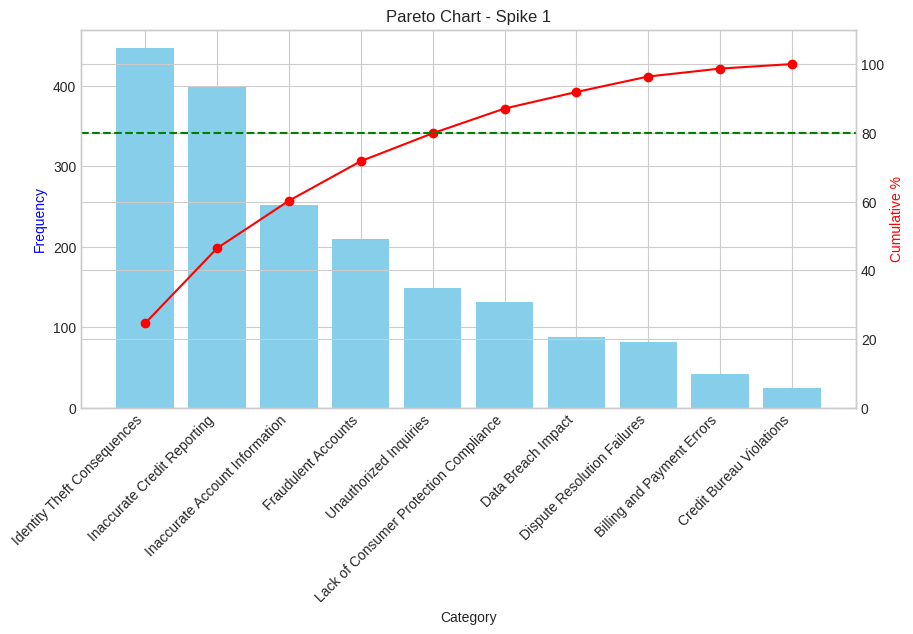

In [ ]:
pareto(spike1.CauseCategory.value_counts(),"Pareto Chart - Spike 1")

### Spike 2

In [ ]:
# Spike 2
spike2 = splitting(RCA_spike2_final)
spike2.CauseCategory.value_counts()

,count
CauseCategory,
5,320
9,230
3,228
6,202
7,177
2,165
10,108
1,102
4,93


In [ ]:
spike2 = spike2[spike2["CauseCategory"]!="1. 7"]

In [ ]:
spike2.CauseCategory.value_counts()

,count
CauseCategory,
5,320
9,230
3,228
6,202
7,177
2,165
10,108
1,102
4,93


In [ ]:
# Mapping the number to the category name
cat_spike2 = {
    "1": "Unauthorized Account Openings",
    "2": "Inaccurate Account Information",
    "3": "Identity Theft-Related Fraud",
    "4": "Unconsented Credit Inquiries",
    "5": "Inaccurate Credit Reporting Practices",
    "6": "Data Breach-Related Identity Theft",
    "7": "Unresolved Disputes and Investigations",
    "8": "Inaccurate Credit Scoring",
    "9": "Unauthorized Credit Report Entries",
    "10": "Mismanaged Account Information"
}

spike2["CauseCategory"] = spike2["CauseCategory"].map(cat_spike2)

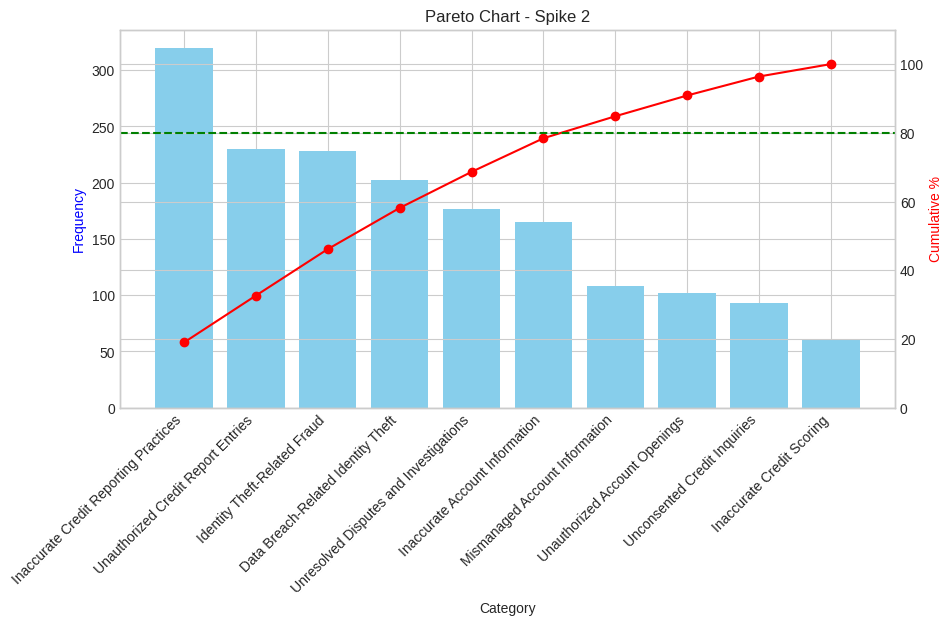

In [ ]:
pareto(spike2.CauseCategory.value_counts(),"Pareto Chart - Spike 2")

### Baseline

In [ ]:
# Spike 2
baseline = splitting(RCA_baseline_final)
baseline.CauseCategory.value_counts()

,count
CauseCategory,
9,348
6,342
5,217
7,176
1,174
2,160
3,120
10,113
4,89


In [ ]:
baseline = baseline[~baseline["CauseCategory"].str.contains(r"\.")]

In [ ]:
baseline.CauseCategory.value_counts()

,count
CauseCategory,
9,348
6,342
5,217
7,176
1,174
2,160
3,120
10,113
4,89


In [ ]:
# Mapping the number to the category name
cat_baseline = {
    "1": "Fraudulent Account Opening",
    "2": "Unauthorized Credit Inquiries",
    "3": "Inaccurate Credit Reporting",
    "4": "Debt Collection Errors",
    "5": "Identity Theft-Related Issues",
    "6": "Credit Bureau Reporting Mistakes",
    "7": "Dispute Resolution Failures",
    "8": "Unauthorized Sharing of Personal Information",
    "9": "Credit Reporting Violations",
    "10": "Account Closure and Re-aging Discrepancies"
}

baseline["CauseCategory"] = baseline["CauseCategory"].map(cat_baseline)

/tmp/ipython-input-3650963696.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline["CauseCategory"] = baseline["CauseCategory"].map(cat_baseline)


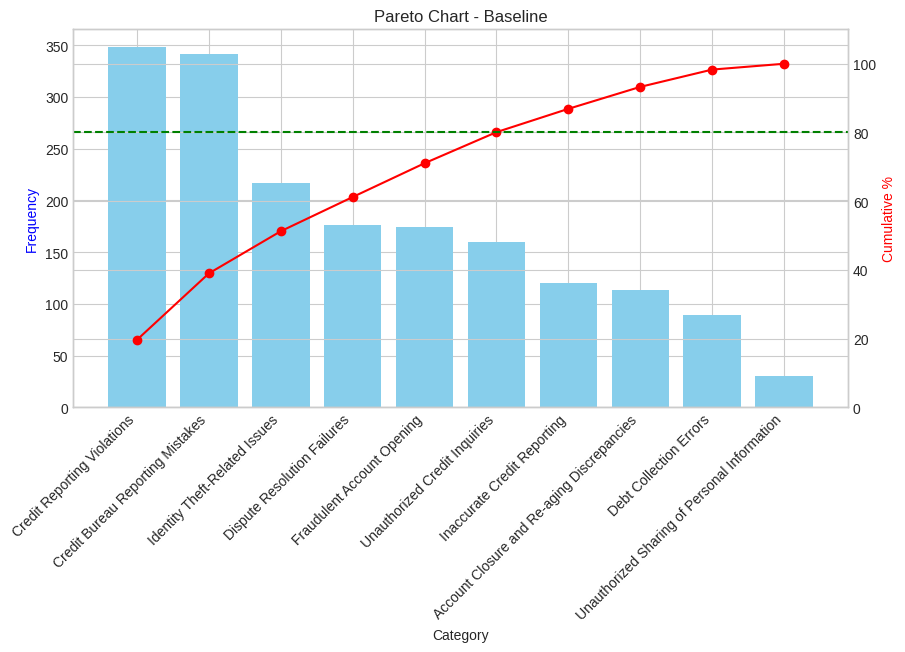

In [ ]:
pareto(baseline.CauseCategory.value_counts(),"Pareto Chart - Baseline")

Thank You!